In [5]:
import seabreeze
import numpy as np
import matplotlib.pyplot as plt
from seabreeze.spectrometers import Spectrometer
import time
import matplotlib.pylab as pl
from IPython import display
import os
import datetime

In [6]:
class ocean_optics_spectrometer():
    '''This class is used to operate the ocean labs spectrometer'''
    # Created by Rouven
    
    def __init__(self):
        try:
            self.spec = Spectrometer.from_first_available()
            print('Spectrometer successfully initialized')
        except Exception as error:
            print(error)
            return
        self.av = 1  # Number of averages for averaged spectra
        self.int_time = 1e5       # Integration time of spectrometer (variable)
        self.set_int_time(self.int_time)    # Integration time of spectrometer (actually setting it)
        self.background_exists = False
        self.file_name = 'Unnamed_Spectrum'           # Name saved file
        self.target_directory = os.path.abspath('.')  # Target directory for saved files
    
    def close(self):
        '''Closes the spectrometer'''
        self.spec.close()
    
    def set_int_time(self, integration_time=1e5):
        '''Sets the integration time [mus]'''
        self.spec.integration_time_micros(integration_time)
        self.int_time = integration_time
    
    def set_background(self, integr = None, aver = None, plot = True):
        '''Records an averaged spectrum and saves it as background for later use'''
        if integr == None:
            integr = self.int_time
        if aver == None:
            aver = self.av
        self.get_av_spectrum(integr = integr, aver = aver, plot = plot)
        self.background_exists = True
        self.background = self.mean_spec
        self.background_int = integr
        self.background_av = aver
        print('Backgroundspectrum successfully recorded')
    
    def save_data(self):
        '''Saves spectra to '''
        date = str(datetime.date.today()).replace('-','') + '_'
        if not os.path.exists(self.target_directory):
            os.mkdir(self.target_directory)
            print('Created directory', self.target_directory)
        full_path = os.path.join(self.target_directory, date + self.file_name)
        i = 0
        while os.path.isfile(full_path + '_' + str(i) + '.txt'):    # Enumerate Files to not override
            i+=1
        if self.background_exists:
            self.all_data = np.array([self.wavelengths, self.background, self.mean_spec, self.mean_spec - self.background])
        else:
            self.all_data = np.array([self.wavelengths, self.mean_spec])
        np.savetxt(full_path + '_' + str(i) + '.txt', self.all_data.T)
        self.plot_spectra(x=[self.all_data[0]], y=[self.all_data[-1]], title = self.file_name + '_' + str(i), save = True, savepath = full_path+ '_' + str(i))
        print('Saved successfully: ', full_path)
        
    def remove_background(self):
        '''Removes the currently stored background spectrum'''
        if self.background_exists:
            del self.background, self.background_int, self.background_av
            self.background_exists = False
        
    def get_spec_min_bg(self, integr = None, aver = None, plot = True, save_data = False):
        '''Records an averaged spectrum and subtracts the background spectrum. Can save the data.'''
        if integr == None:
            integr = self.int_time
        if aver == None:
            aver = self.av
        #Todo: check if background exists
        if not self.background_exists:
            print('No background spectrum recorded yet! Use my_spec.set_background() first')
            return
        if self.background_int != integr:
            print('Warning, integration time of background and spectrum do not match ({:} and {:} mus)'.format(self.background_int, integr))
        if self.background_av != aver:
            print('Warning, integration time of background and spectrum do not match ({:} and {:} mus)'.format(self.background_av, aver))
        self.get_av_spectrum(integr = integr, aver = aver, plot = plot)
        self.mean_spec_m_bg = self.mean_spec - self.background
        self.plot_spectra(x = [self.wavelengths], y = [self.mean_spec_m_bg], title = 'Subtracted Spectrum')
        if save_data:
            self.save_data()
        
    def get_av_spectrum(self, integr = None, aver = None, plot = True):
        '''Records an averaged spectrum. Can be interrupted via keyboard interrupt.'''
        if integr == None:
            integr = self.int_time
        if aver == None:
            aver = self.av
        self.set_int_time(integr)
        time.sleep(1)    # Safety for setting the integration time
        self.all_spec =[]
        for n in range(aver):
            t_wait = 0
            seconds_passed = 0
            try:
                while t_wait < integr/1e6:   #wait loop during integration
                    time.sleep(min([integr/1e6,1]))
                    t_wait+=min([integr/1e6,1])
                    if t_wait//1 > seconds_passed:
                        seconds_passed+=1
                        print('\r' + 'Average: {:}/{:}, Seconds passed: {:}/{:.0f}'.format(n+1, aver, int(n*integr/1e6) + seconds_passed, integr/1e6*aver) , end = "")
            except KeyboardInterrupt:
                return
            self.read_spectrum()
            self.live_plot(curr_av = n)
            self.all_spec.append(self.counts)
            self.mean_spec = np.mean(np.array(self.all_spec), axis = 0)
        self.final_plot()
        self.set_int_time()
    
    def plot_spectra(self, x, y, title, save = False, savepath = 'No_path_provided'):
        fig, ax = plt.subplots(figsize = (15,5), dpi = 300)
        for xi, yi in zip(x,y):
            ax.plot(xi,yi)
        ax.set_title(title)
        ax.set_xlabel('Wavelength [nm]')
        ax.set_ylabel('Counts')
        if save:
            plt.savefig(savepath + '.png', dpi = 300, facecolor = 'w')
            plt.close(fig)
        else:
            plt.show()
    
    def final_plot(self):
        plt.figure(figsize = (15,5), dpi = 300)
        plt.title('Averaged Spectra')
        plt.xlabel('Wavelength [nm]')
        plt.ylabel('Counts')
        for s in self.all_spec:
            plt.plot(self.wavelengths, s, alpha = 0.2)
        plt.plot(self.wavelengths, self.mean_spec)
        plt.show()
    
    def live_plot(self, curr_av):
        '''function used for live-plots during the recording of averaged spectra'''
        pl.figure(figsize = (15,5), dpi = 300)
        pl.plot(self.wavelengths, self.counts)
        pl.xlim()
        pl.ylim()
        pl.title('Average {:}/{:}'.format(curr_av+1, self.av))
        display.display(pl.gcf())
        display.clear_output(wait=True)    #only show one plot at a time
        pl.show()
        
    def read_spectrum(self):
        '''Reads out the spectrum from the spectrometer. Removes the darkcounts'''
        spectrum = self.spec.spectrum(correct_dark_counts=True)
        self.spectrum = [spectrum[0], spectrum[1]]
        self.wavelengths = self.spectrum[0]
        self.counts = self.spectrum[1]    

In [7]:
# Initialize the spectrometer
try:                     # try except is necessary if the spectrometer is still in use
    my_spec.close()
except NameError:
    pass
my_spec = ocean_optics_spectrometer()

Spectrometer successfully initialized


In [8]:
# First step: Parameters
my_spec.int_time = 1e5   # Set the integration time of the spectrometer in [mus]
my_spec.av = 2              # Number of averages for averaged spectra
my_spec.target_directory = 'Data'  # Directory for saved data and figures
my_spec.file_name = 'test_spectrum'  # Filename for saved data

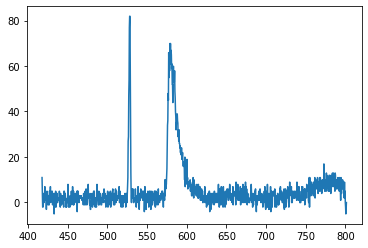

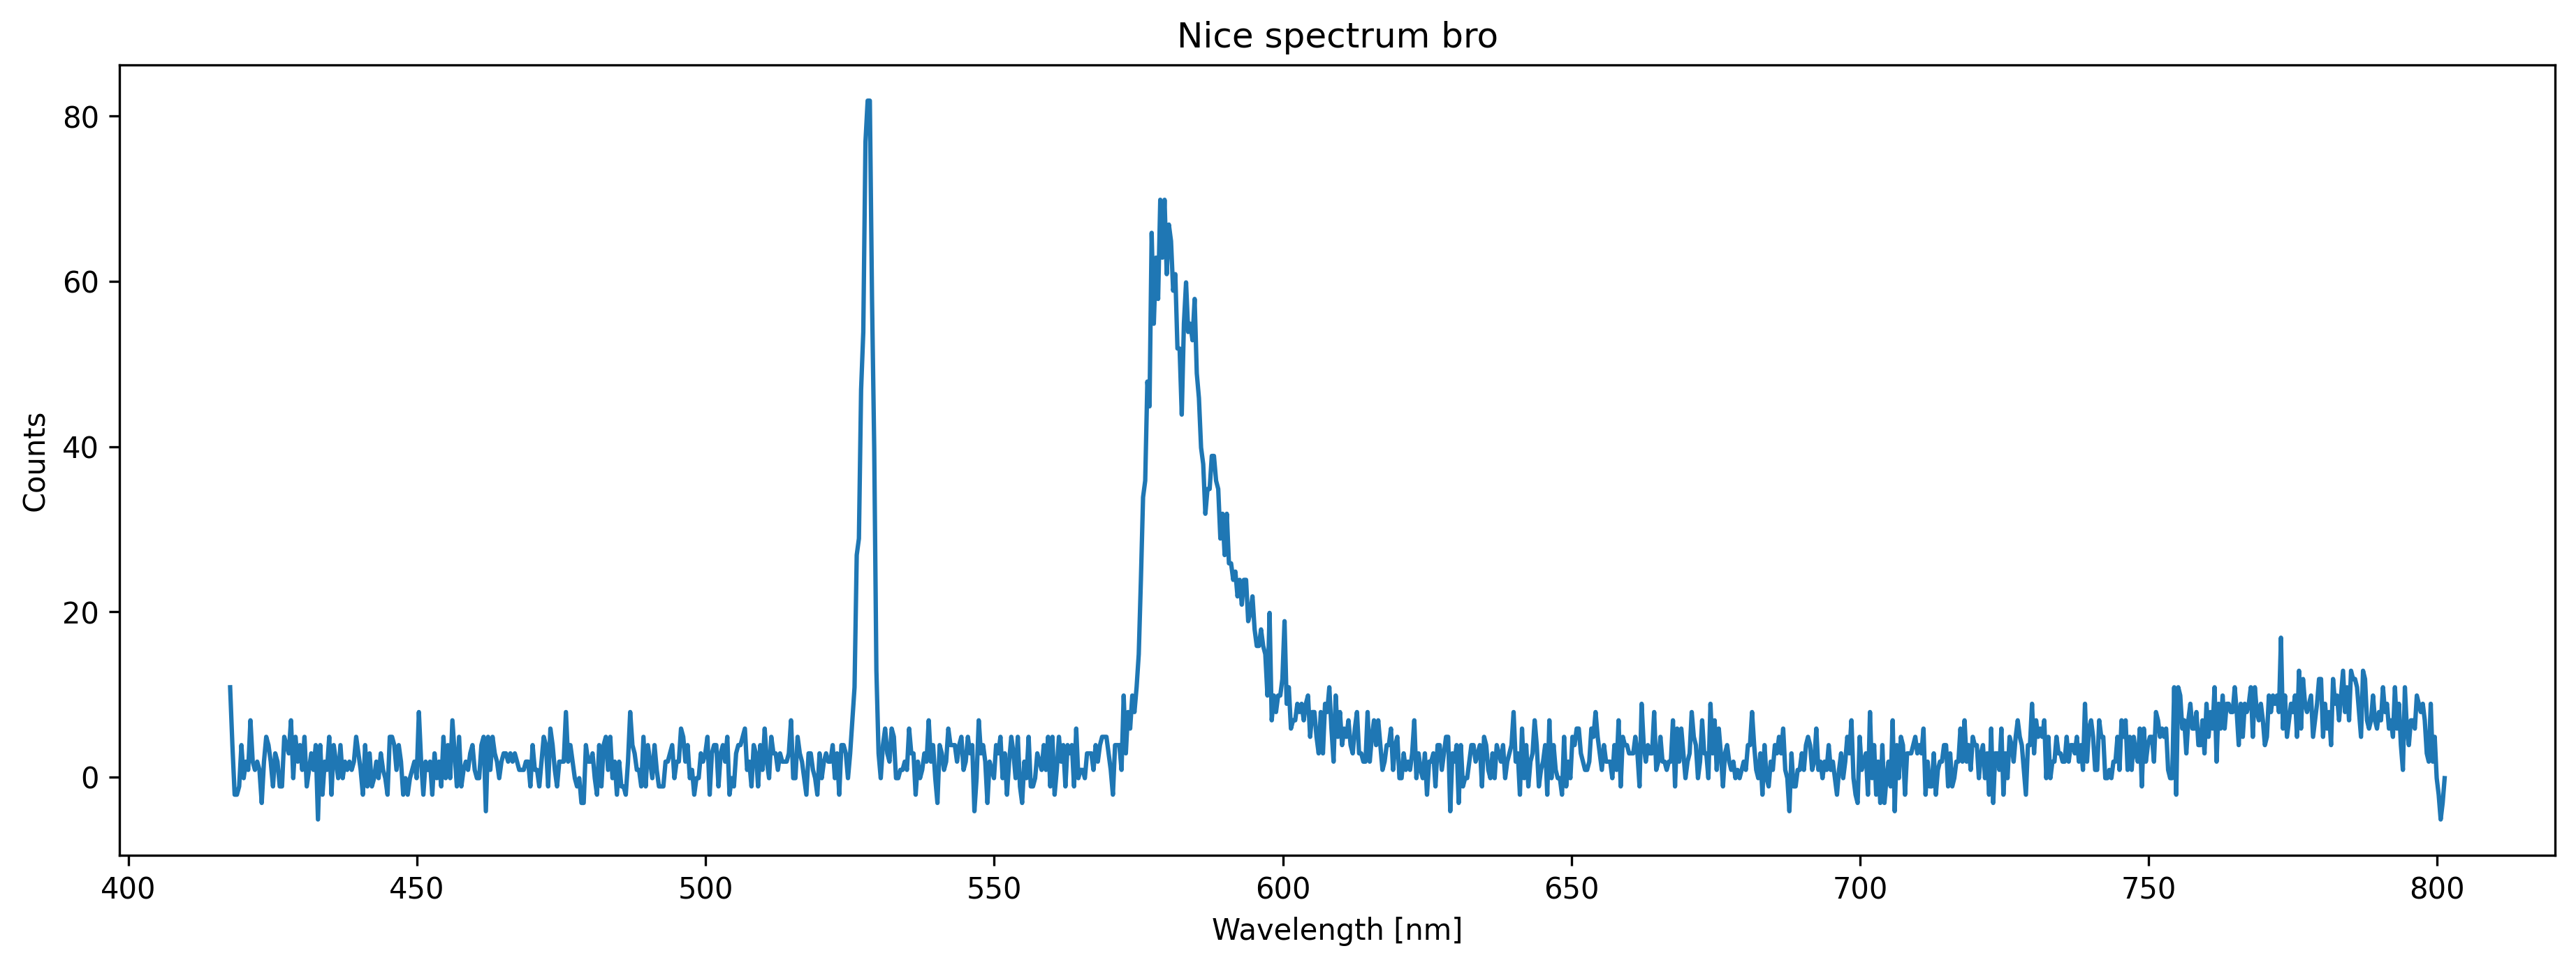

In [9]:
# Read out a single spectrum
my_spec.set_int_time(1*1e6) # For this you need to manually set the integration time
my_spec.read_spectrum()
plt.plot(my_spec.wavelengths, my_spec.counts)  # or:
#plt.plot(my_spec.spectrum[0], my_spec.spectrum[1])
plt.show()

# You can also use the builtin function:
my_spec.plot_spectra([my_spec.wavelengths], [my_spec.counts], title = 'Nice spectrum bro', save = False)

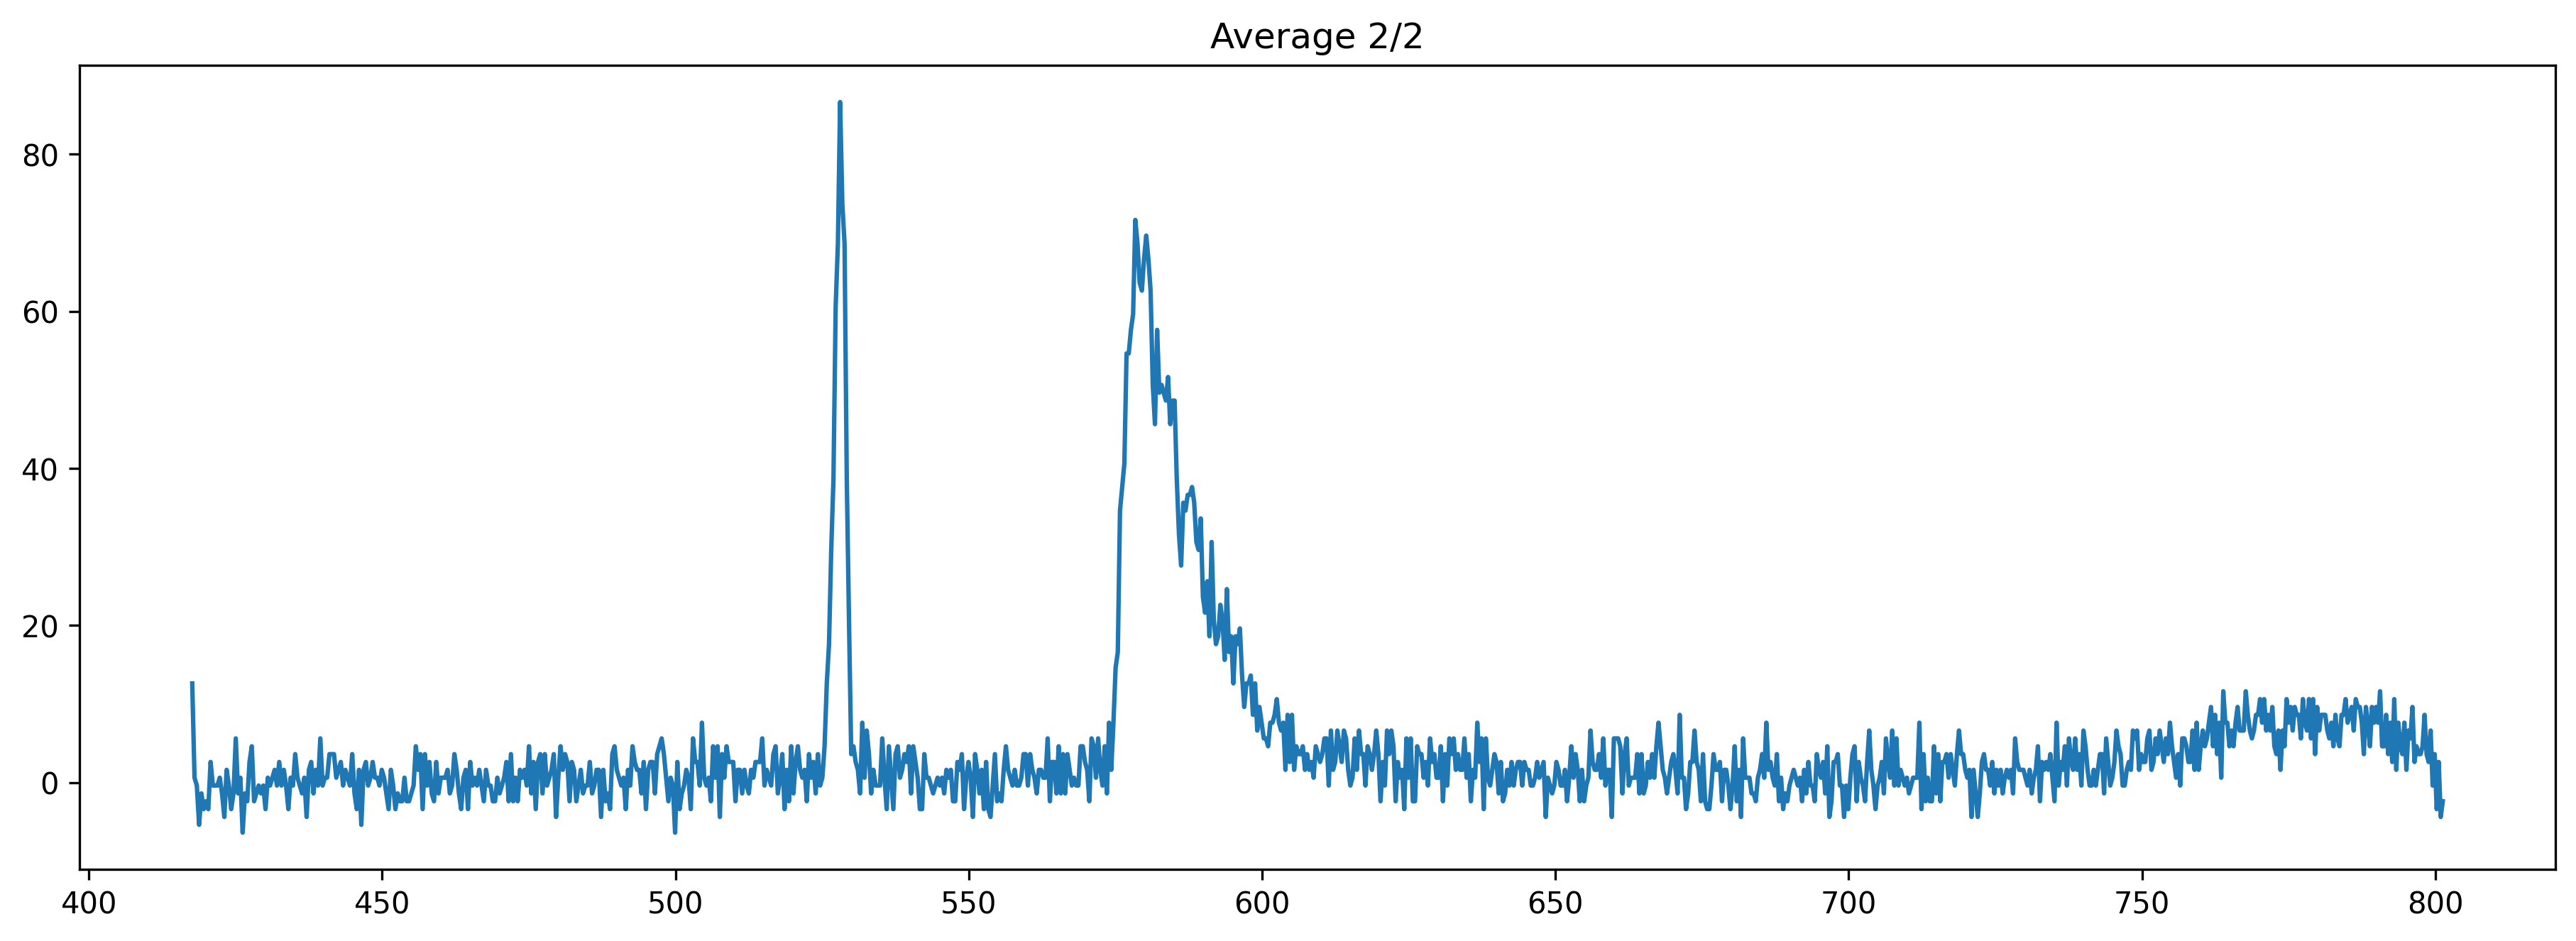

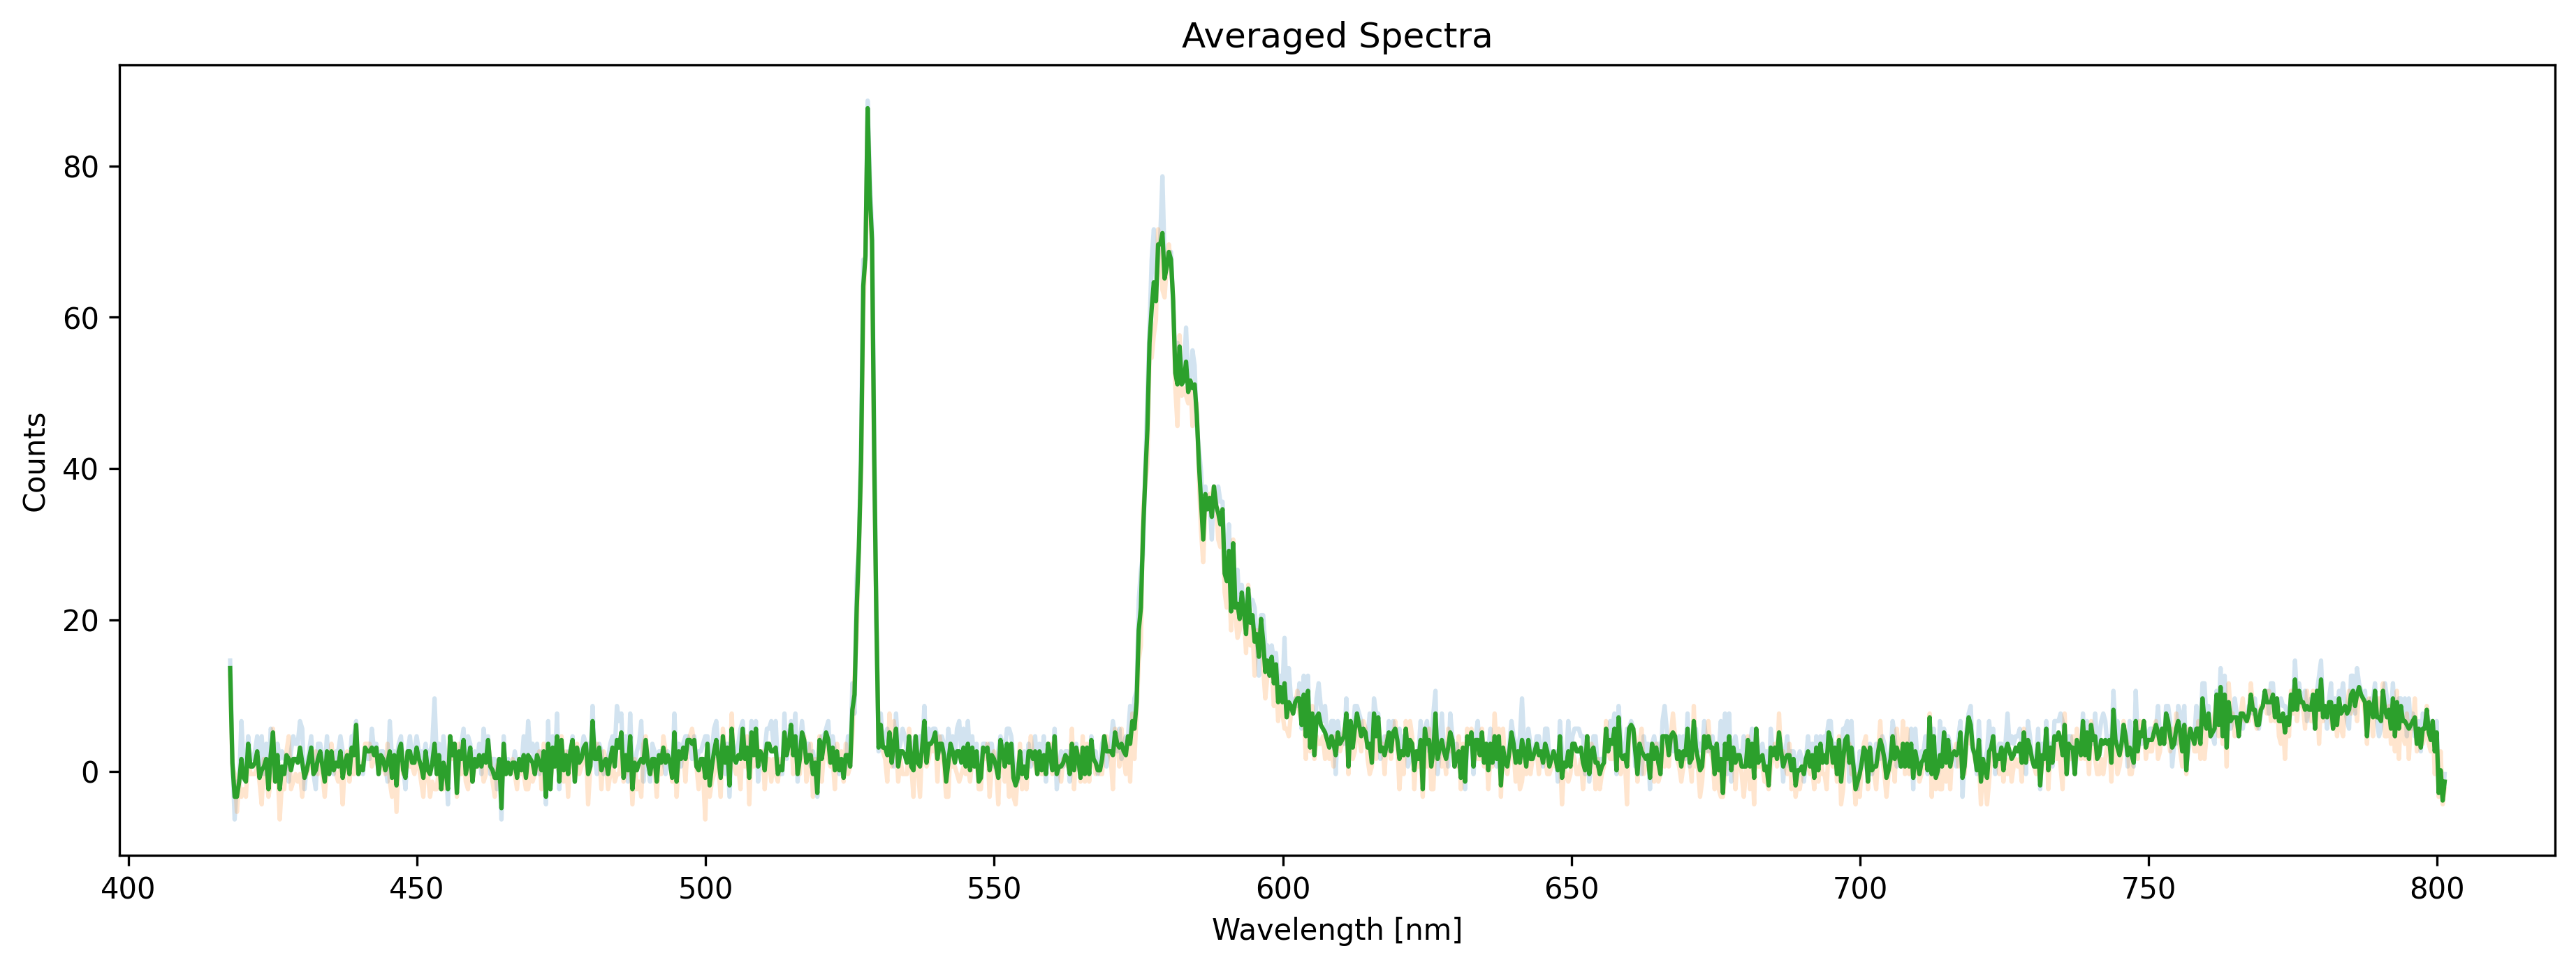

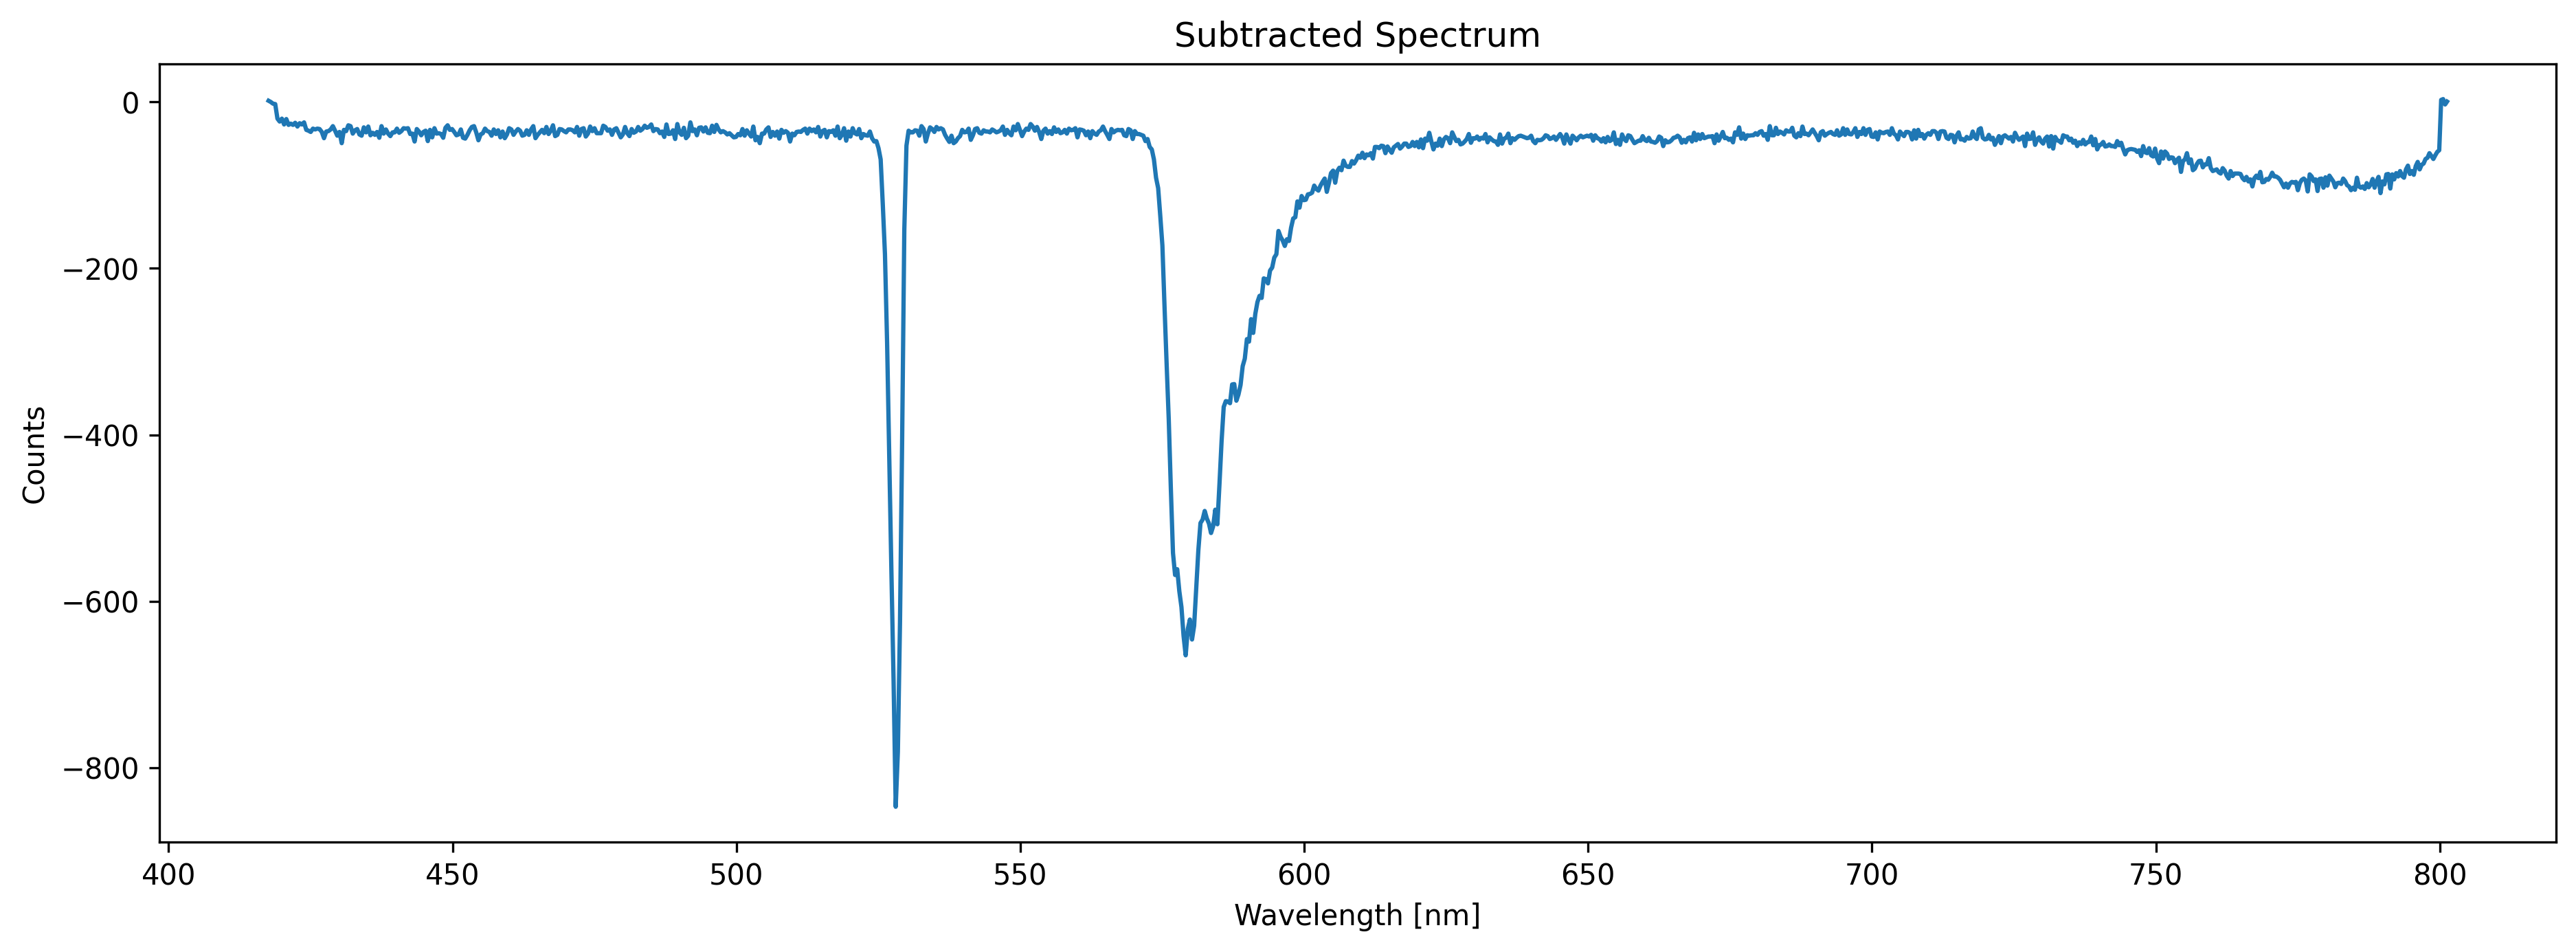

Saved successfully:  Data\20240222_test_spectrum


In [12]:
# Create a Background spectrum and subtract it from you real data:
my_spec.int_time = 1e6
my_spec.set_background()    # this creates an averaged spectrum and stores it in my_spec.background

# After recording your background, move to your target position and record the real spectrum:
my_spec.get_spec_min_bg(save_data = True)   # This records again an averaged spectrum and can save the final data 

In [13]:
my_spec.close()